In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Load all locations
files = ['Location1.csv', 'Location2.csv', 'Location3.csv', 'Location4.csv']

dfs = []
for file in files:
    df = pd.read_csv(f'../Data/{file}', parse_dates=['Time'])
    df['Location'] = file.split('.')[0]  # Add location name
    dfs.append(df)

In [3]:
# Combine all locations
data = pd.concat(dfs).sort_values(by=['Time', 'Location'])
data.set_index('Time', inplace=True)

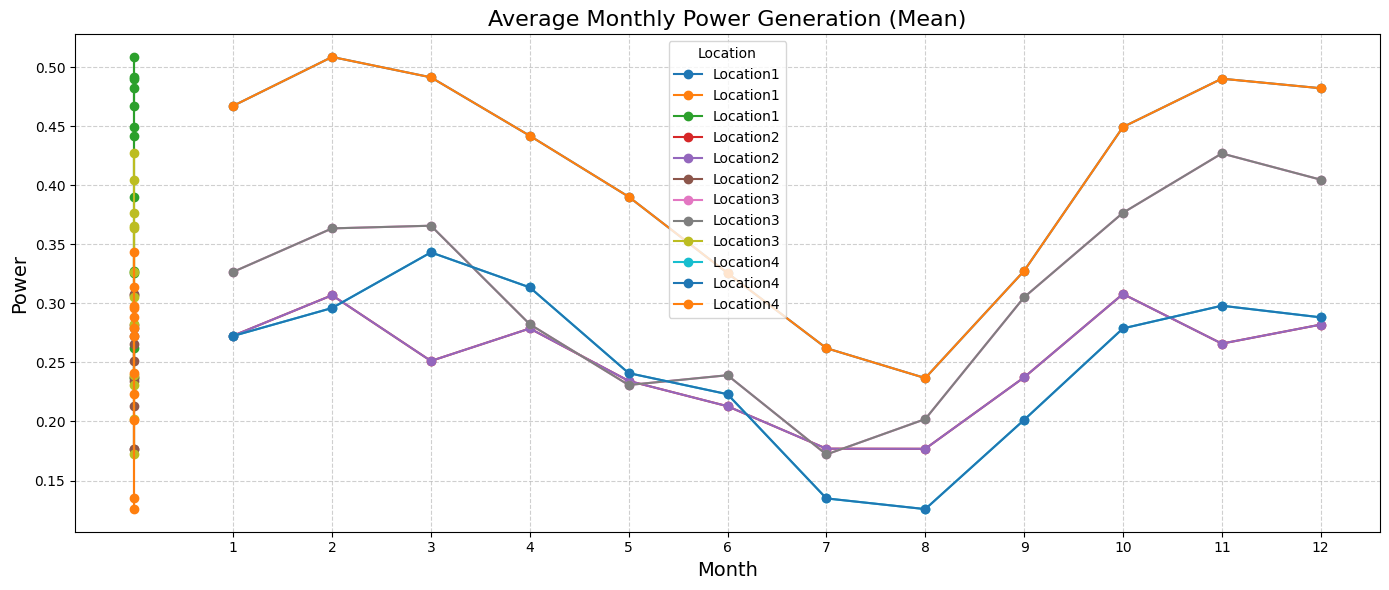

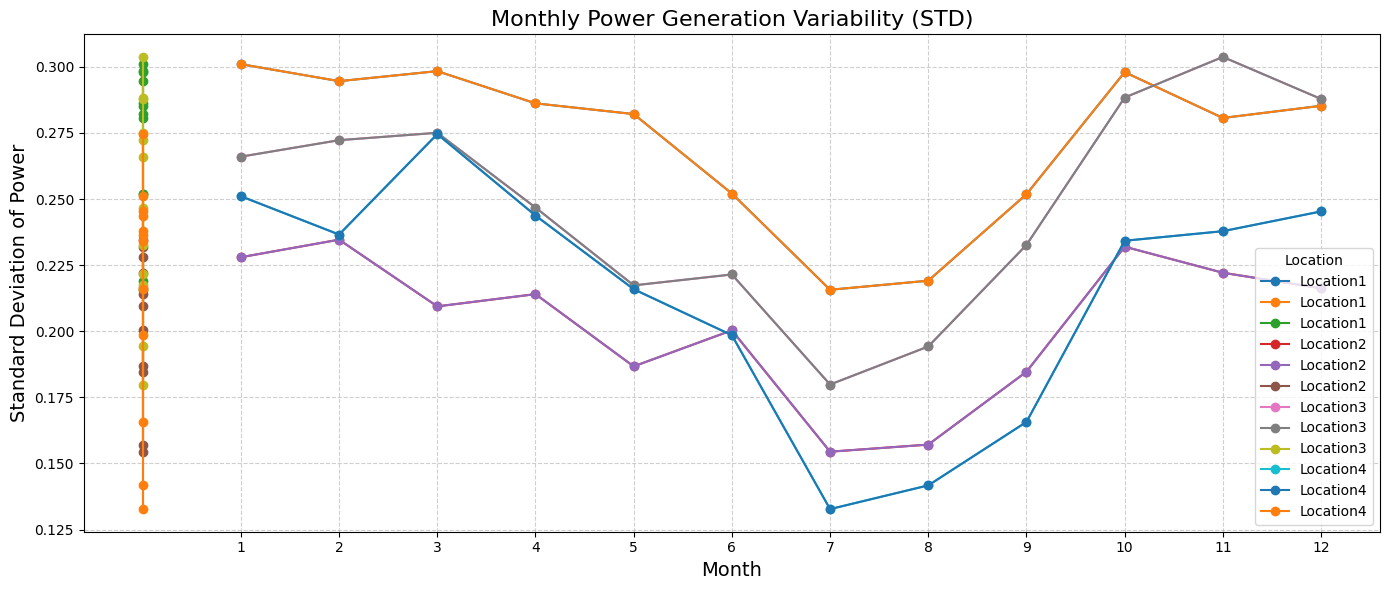

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ----------- Preparation -----------
# Assuming you have 'data' loaded with DatetimeIndex

# Ensure 'Month' column exists
data['Month'] = data.index.month

# Select only numeric columns
numeric_cols = data.select_dtypes(include='number').columns

# Aggregate only on numeric columns (mean & std)
monthly_stats = data.groupby(['Month', 'Location'])[numeric_cols].agg(['mean', 'std']).reset_index()

# ----------- Plotting (Separate Mean and STD) -----------

# Mean plot
plt.figure(figsize=(14, 6))
for loc in data['Location'].unique():
    subset = monthly_stats[monthly_stats['Location'] == loc]
    plt.plot(subset['Month'], subset[('Power', 'mean')], marker='o', label=loc)
plt.title("Average Monthly Power Generation (Mean)", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Power", fontsize=14)
plt.xticks(range(1, 13))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Location')
plt.tight_layout()
plt.show()

# STD plot
plt.figure(figsize=(14, 6))
for loc in data['Location'].unique():
    subset = monthly_stats[monthly_stats['Location'] == loc]
    plt.plot(subset['Month'], subset[('Power', 'std')], marker='o', label=loc)
plt.title("Monthly Power Generation Variability (STD)", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Standard Deviation of Power", fontsize=14)
plt.xticks(range(1, 13))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Location')
plt.tight_layout()
plt.show()


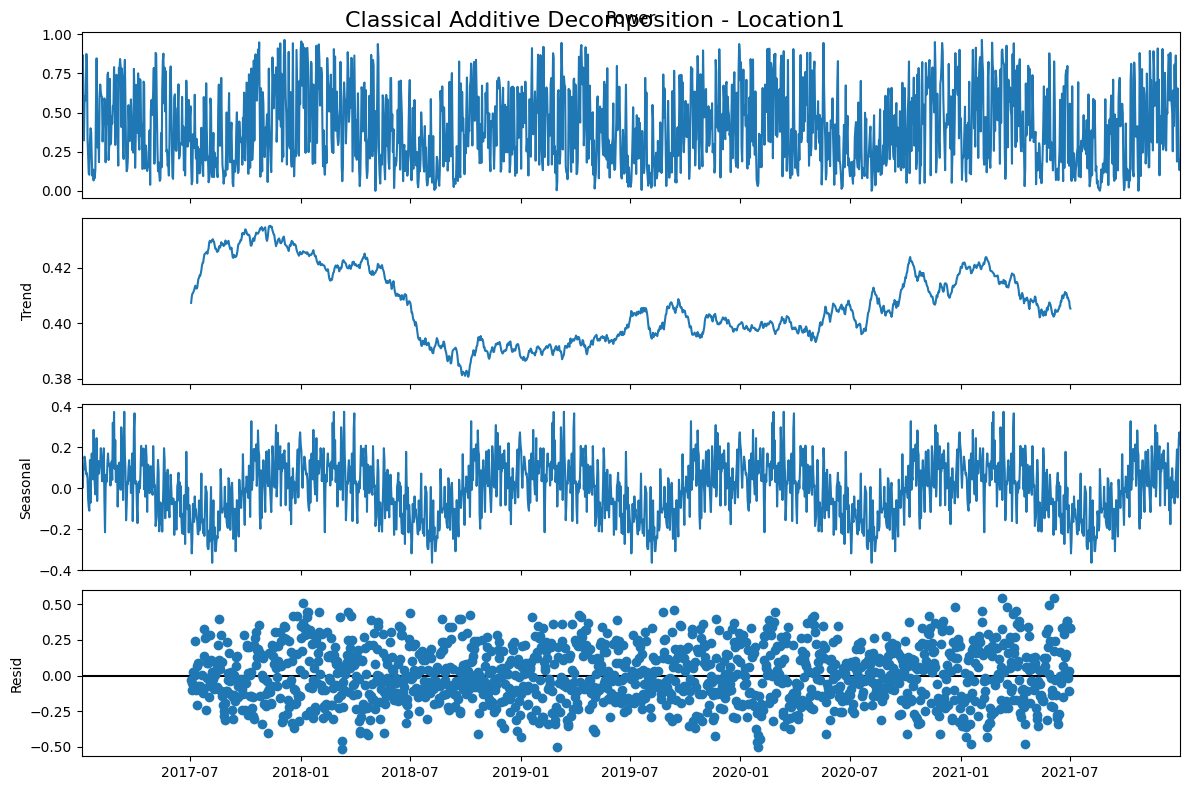

In [9]:

# First, aggregate your data into daily or weekly frequency to make decomposition clearer
daily_data = data.groupby([data.index.date, 'Location'])['Power'].mean().reset_index()
daily_data['Date'] = pd.to_datetime(daily_data['level_0'])  # convert back to datetime
daily_data = daily_data.drop('level_0', axis=1)

# For simplicity, let's select one location first
loc = data['Location'].unique()[0]
loc_data = daily_data[daily_data['Location'] == loc].set_index('Date')

# Make sure the time series is complete (no missing dates)
loc_data = loc_data.asfreq('D')

# Classical decomposition
decomposition = seasonal_decompose(loc_data['Power'], model='additive', period=365)

# Plot the decomposition
plt.rcParams.update({'figure.figsize': (12, 8)})
decomposition.plot()
plt.suptitle(f"Classical Additive Decomposition - {loc}", fontsize=16)
plt.show()


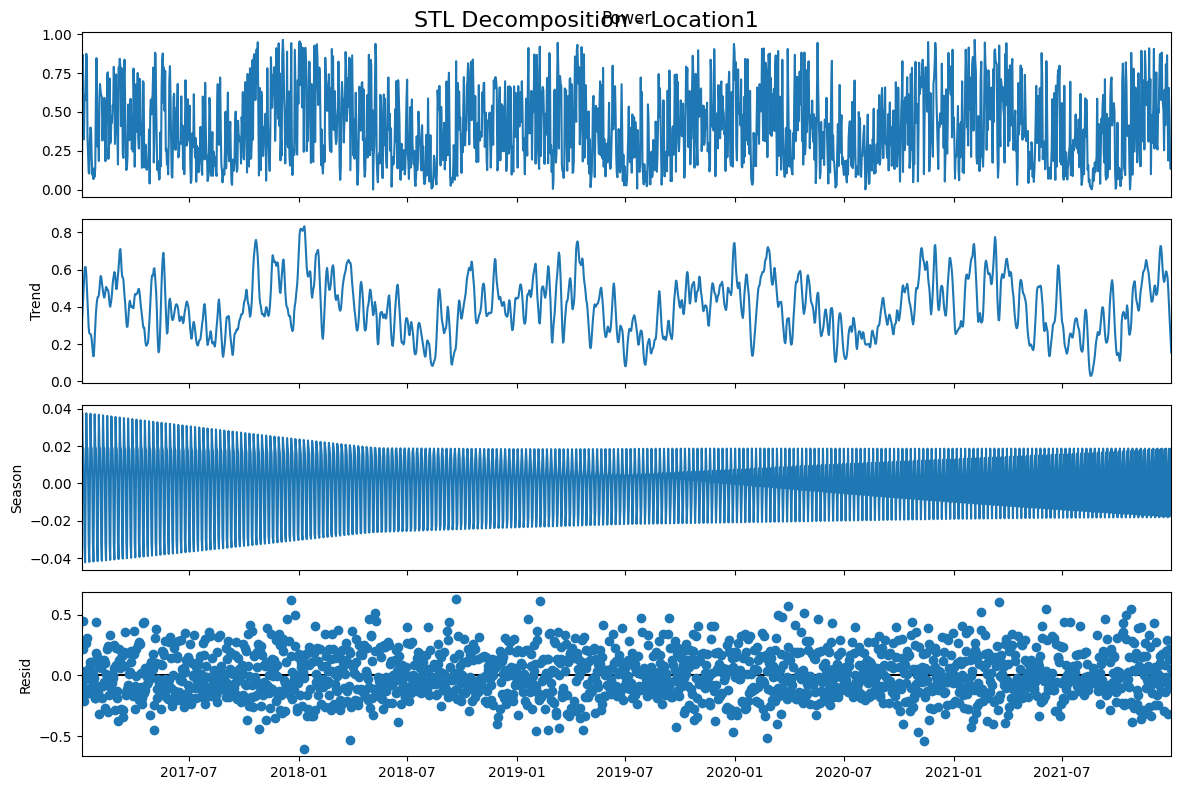

In [10]:
from statsmodels.tsa.seasonal import STL

# We can reuse the daily frequency data for a single location as before
loc = data['Location'].unique()[0]
loc_data = daily_data[daily_data['Location'] == loc].set_index('Date')
loc_data = loc_data.asfreq('D')

# STL decomposition (specify seasonal period — for daily data with yearly seasonality, ~365)
stl = STL(loc_data['Power'], seasonal=365, robust=True)
result = stl.fit()

# Plot the decomposition
plt.rcParams.update({'figure.figsize': (12, 8)})
result.plot()
plt.suptitle(f"STL Decomposition - {loc}", fontsize=16)
plt.show()


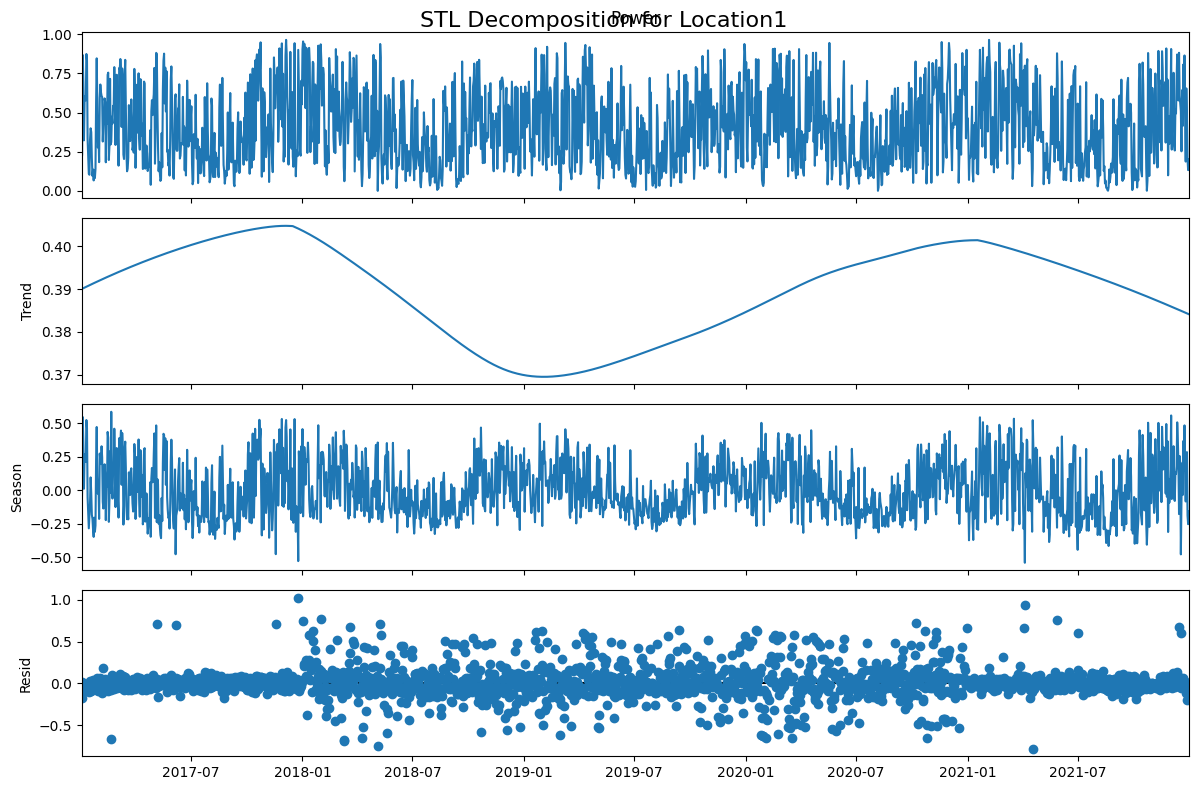

In [12]:
import statsmodels.api as sm

# Select one location for decomposition
loc = 'Location1'
loc_data = data[data['Location'] == loc]

# Resample on daily frequency, applying mean only on numeric columns
numeric_cols = loc_data.select_dtypes(include='number').columns
loc_data_resampled = loc_data[numeric_cols].resample('D').mean()

# Handle any NaNs (STL needs complete data)
loc_data_resampled['Power'] = loc_data_resampled['Power'].interpolate()

# STL decomposition
stl = sm.tsa.STL(loc_data_resampled['Power'], period=365, robust=True)
result_stl = stl.fit()

# Plot
plt.rcParams.update({'figure.figsize': (12, 8)})
result_stl.plot()
plt.suptitle(f'STL Decomposition for {loc}', fontsize=16)
plt.show()



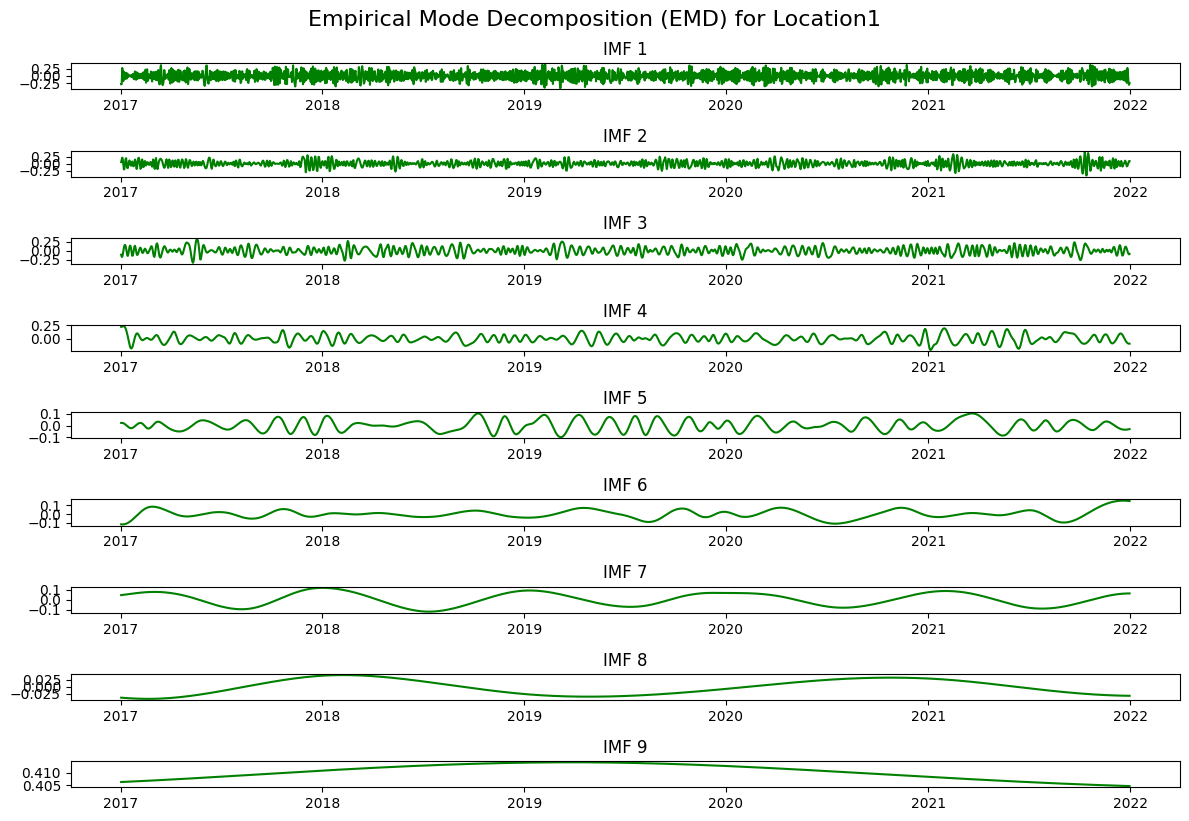

In [13]:
from PyEMD import EMD

# Again selecting one location
loc = 'Location1'
loc_data = data[data['Location'] == loc]

# Resample daily on numeric data
numeric_cols = loc_data.select_dtypes(include='number').columns
loc_data_resampled = loc_data[numeric_cols].resample('D').mean()

# Handle missing values (interpolate if needed)
power_series = loc_data_resampled['Power'].interpolate().values
time_series = loc_data_resampled.index.values

# Apply EMD
emd = EMD()
IMFs = emd(power_series)

# Plot the IMFs
plt.figure(figsize=(12, 8))
for n, imf in enumerate(IMFs):
    plt.subplot(len(IMFs), 1, n+1)
    plt.plot(loc_data_resampled.index, imf, 'g')
    plt.title(f"IMF {n+1}")
    plt.tight_layout()

plt.suptitle(f"Empirical Mode Decomposition (EMD) for {loc}", y=1.02, fontsize=16)
plt.show()


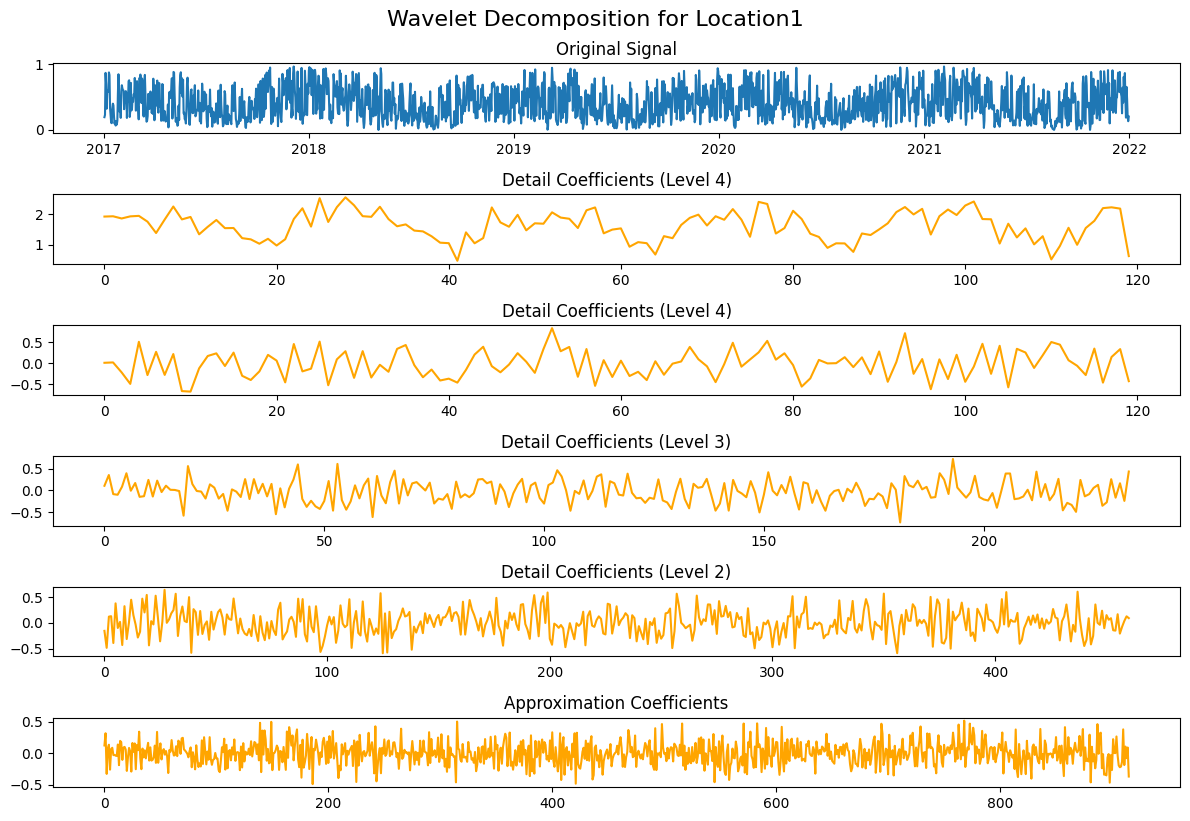

In [14]:
import pywt

# Again, select one location for simplicity
loc = 'Location1'
loc_data = data[data['Location'] == loc]

# Resample daily on numeric data
numeric_cols = loc_data.select_dtypes(include='number').columns
loc_data_resampled = loc_data[numeric_cols].resample('D').mean()

# Interpolate missing values
power_series = loc_data_resampled['Power'].interpolate().values

# Perform Wavelet Decomposition
wavelet = 'db4'  # Daubechies 4 wavelet
level = 4  # You can change levels depending on your data size

coeffs = pywt.wavedec(power_series, wavelet, level=level)

# Plot each decomposition level
plt.figure(figsize=(12, 8))
plt.subplot(level+2, 1, 1)
plt.plot(loc_data_resampled.index, power_series)
plt.title('Original Signal')

for i, coeff in enumerate(coeffs):
    plt.subplot(level+2, 1, i+2)
    plt.plot(coeff, color='orange')
    if i == 0:
        plt.title(f'Detail Coefficients (Level {level})')
    else:
        plt.title(f'Detail Coefficients (Level {level - i + 1})' if i != len(coeffs)-1 else 'Approximation Coefficients')

plt.tight_layout()
plt.suptitle(f"Wavelet Decomposition for {loc}", y=1.02, fontsize=16)
plt.show()


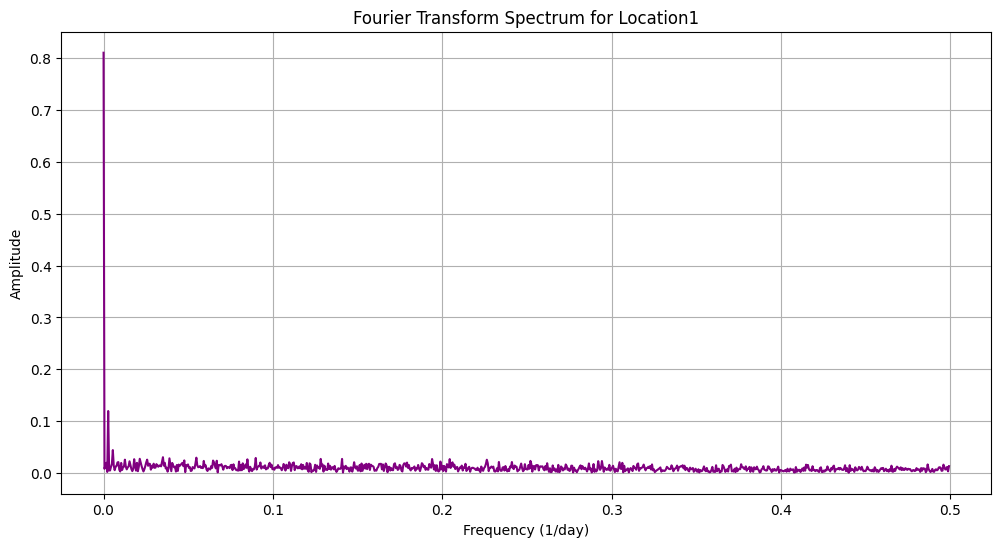

In [15]:
import numpy as np
from scipy.fft import fft, fftfreq, ifft

# Select one location again
loc = 'Location1'
loc_data = data[data['Location'] == loc]

# Resample daily on numeric data
numeric_cols = loc_data.select_dtypes(include='number').columns
loc_data_resampled = loc_data[numeric_cols].resample('D').mean()

# Interpolate missing values
power_series = loc_data_resampled['Power'].interpolate().values
N = len(power_series)
T = 1.0  # Assuming 1 day interval

# Apply Fourier Transform
yf = fft(power_series)
xf = fftfreq(N, T)[:N//2]

# Plot Frequency Spectrum
plt.figure(figsize=(12, 6))
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]), color='purple')
plt.title(f"Fourier Transform Spectrum for {loc}")
plt.xlabel('Frequency (1/day)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()


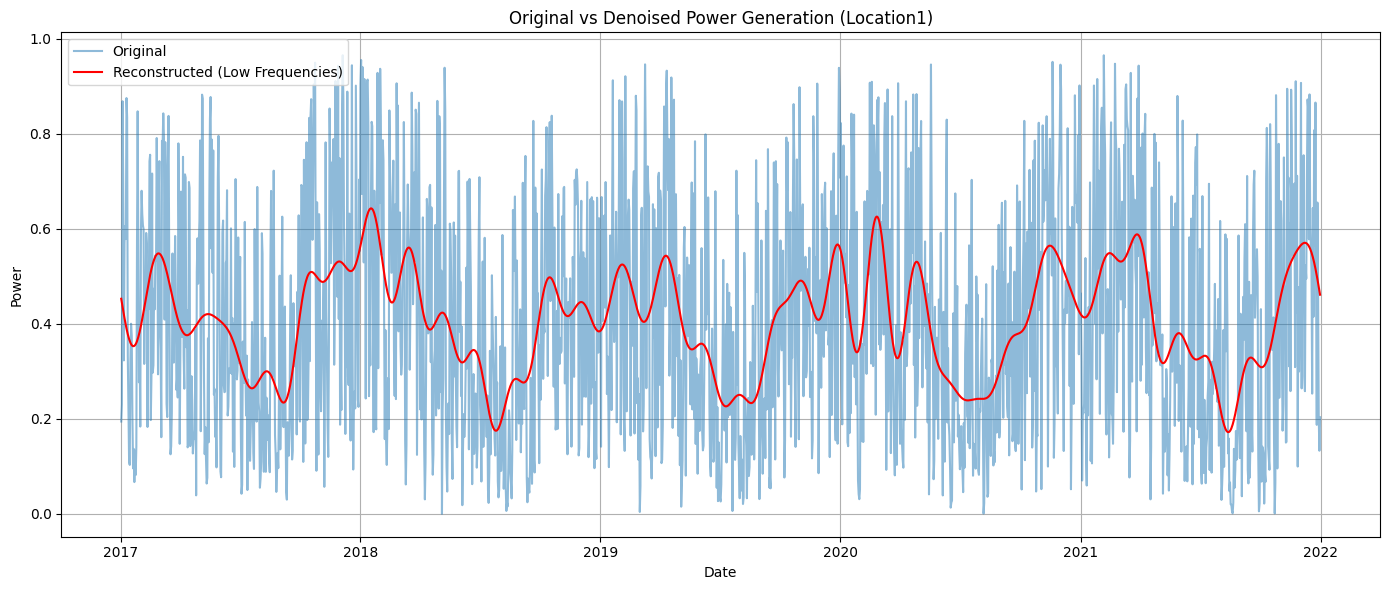

In [16]:
import numpy as np
from scipy.fft import fft, fftfreq, ifft

# Select one location again
loc = 'Location1'
loc_data = data[data['Location'] == loc]
numeric_cols = loc_data.select_dtypes(include='number').columns
loc_data_resampled = loc_data[numeric_cols].resample('D').mean()
power_series = loc_data_resampled['Power'].interpolate().values

N = len(power_series)
T = 1.0  # 1 day interval

# Apply Fourier Transform
yf = fft(power_series)
xf = fftfreq(N, T)

# Filtering: Zero out high frequencies (keep only low frequencies)
cutoff = 0.02  # Keep frequencies below this value
filtered_yf = yf.copy()
filtered_yf[np.abs(xf) > cutoff] = 0

# Inverse Fourier Transform (Reconstruction)
reconstructed_series = ifft(filtered_yf).real

# Plot original vs reconstructed
plt.figure(figsize=(14,6))
plt.plot(loc_data_resampled.index, power_series, label='Original', alpha=0.5)
plt.plot(loc_data_resampled.index, reconstructed_series, label='Reconstructed (Low Frequencies)', color='red')
plt.title(f"Original vs Denoised Power Generation ({loc})")
plt.xlabel('Date')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


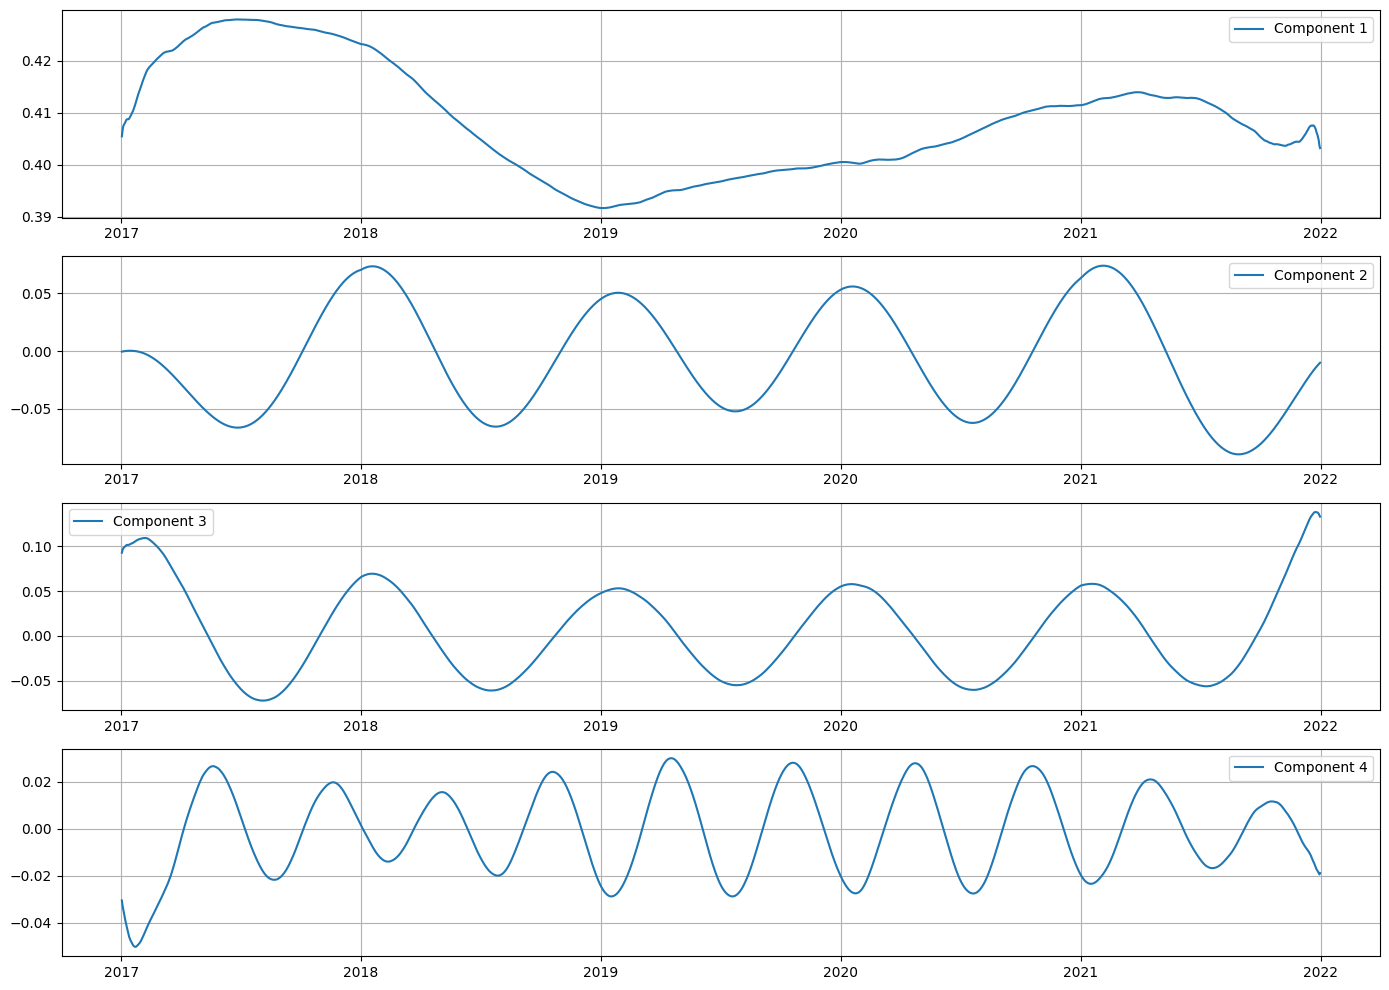

In [18]:
from pyts.decomposition import SingularSpectrumAnalysis

# Prepare data (again daily interpolated)
X = power_series.reshape(1, -1)

# Apply SSA
window_size = 365  # roughly 1 year window
ssa = SingularSpectrumAnalysis(window_size=window_size)
X_ssa = ssa.fit_transform(X)

# Plot components
plt.figure(figsize=(14, 10))

for i in range(4):  # First 4 components
    plt.subplot(4, 1, i + 1)
    plt.plot(loc_data_resampled.index, X_ssa[0, i], label=f'Component {i+1}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
